## Introduction

In this notebook, we perform image classification on the CIFAR-10 dataset using a linear probing approach applied to a pre-trained AlexNet model. While the original AlexNet was designed for larger images (224x224) and 1,000-class classification (ImageNet), here we adapt it for the smaller 32x32 CIFAR-10 images and 10 output classes.

In this linear probing setup:
- We load a version of AlexNet pre-trained on the ImageNet dataset.
- We remove the original final fully connected (classification) layer.
- We replace it with a new linear (dense) layer suitable for 10-class CIFAR-10 classification.
- Other layers remain frozen.

Training is performed using TensorFlow/Keras with using learning rate scheduling and dropout regularization. Model performance is evaluated using  training and validation accuracy.

### Reference
Krizhevsky, A., Sutskever, I., and Hinton, G. E. *ImageNet classification with deep convolutional neural networks.* In Advances in Neural Information Processing Systems (NIPS), pp. 1106–1114, 2012.



In [13]:
import torch
import torchvision.models as models
from torchvision.models import alexnet, AlexNet_Weights
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

## Model Initialization

We initially load the AlexNet model pre-trained on the ImageNet dataset and prepare it for inference or fine-tuning. The pre-trained AlexNet model is loaded from `torchvision.models`.



In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained AlexNet model (trained on ImageNet)
alexnet = models.alexnet(weights=AlexNet_Weights.DEFAULT)
alexnet = alexnet.to(device)
summary(alexnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

## Data Loading and Preprocessing

We next prepare the CIFAR-10 dataset for training and evaluation:

  - **Resize**: Each image is resized from 32x32 pixels to 224x224 pixels to match AlexNet's expected input size.
  - **Normalization**: Pixel values are normalized using the ImageNet mean and standard deviation.

In [10]:
# Data transformation pipeline:
# Resize to 224x224 → Convert to Tensor → Normalize with ImageNet stats
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize CIFAR-10 images from 32x32 to 224x224
    transforms.ToTensor(),          # Convert PIL Image to PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet mean
        std=[0.229, 0.224, 0.225]    # Normalize using ImageNet std deviation
    )
])

# Load CIFAR-10 training and test datasets with the defined transformation
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders for training and testing
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)


100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


## Feature Extraction for Linear Probing

To perform linear probing, we first extract high-level feature representations from the pre-trained AlexNet model. For that purpose, we remove the final classification layer of AlexNet and use the remaining network as a fixed feature extractor.
 For both the training and test sets images are passed through the feature extractor and the resulting feature vectors (of dimension 4096) are collected.
 The extracted features and labels are combined into new `TensorDataset` objects for training and testing.


In [16]:
# Create a feature extractor by removing the final classification layer from AlexNet
feature_extractor = nn.Sequential(*list(alexnet.classifier.children())[:-1])
alexnet.classifier = feature_extractor

# Set model to evaluation mode
alexnet.eval()
alexnet.to(device)

# Containers to store training features and labels
train_features = []
train_labels = []

# Extract features for the training set
with torch.no_grad():
    for images, labels in tqdm(trainloader):
        images = images.to(device)
        features = alexnet(images)  # Output shape: (batch_size, 4096)
        train_features.append(features.cpu())
        train_labels.append(labels)

train_features = torch.cat(train_features)
train_labels = torch.cat(train_labels)

# Cntainers to store testing features and labels
test_features = []
test_labels = []

# Extract features for the testing set
with torch.no_grad():
    for images, labels in tqdm(testloader):
        images = images.to(device)
        features = alexnet(images)  # Output shape: (batch_size, 4096)
        test_features.append(features.cpu())
        test_labels.append(labels)


test_features = torch.cat(test_features)
test_labels = torch.cat(test_labels)

train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 157/157 [00:17<00:00,  8.86it/s]


## Training a Linear Classifier on Extracted Features

In this section, we train a simple linear classifier on top of the 4096-dimensional feature representations extracted from AlexNet. A single fully connected layer is used to map feature vectors to the 10 CIFAR-10 classes Training Setup is as follows:
  - Optimizer: Adam with an initial learning rate of 0.001.
  - Learning rate decay: Exponential decay with a rate of 0.9 applied after each epoch.
  - Loss function: Cross-entropy loss for multi-class classification.

Notice that this approach focuses only on training the final linear layer while keeping the extracted features fixed, following the linear probing methodology.


In [17]:
# Nmber of training epochs
epochs = 75

# Lists to store training and testing metrics per epoch
train_losses = []
train_acc = []
test_losses = []
test_acc = []

# Define a simple linear classifier on top of 4096-dimension features
classifier = nn.Linear(4096, 10).to(device)

# Optimizer: Adam optimizer
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

# Learning rate scheduler: exponential decay with gamma=0.9
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Loss function: Cross-entropy loss
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(epochs):
    classifier.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training dataset
    for features, labels in trainloader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = classifier(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate training loss and correct predictions
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    # Compute average training loss and accuracy for the epoch
    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    train_acc.append(100 * correct / total)

    # Step the learning rate scheduler
    scheduler.step()

    classifier.eval()  # Set model to evaluation mode
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    # Iterate over the test dataset without computing gradients
    with torch.no_grad():
        for features, labels in testloader:
            features, labels = features.to(device), labels.to(device)
            outputs = classifier(features)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_correct += predicted.eq(labels).sum().item()
            test_total += labels.size(0)

    # Average test loss and accuracy for the epoch
    avg_test_loss = test_loss / len(testloader)
    test_accuracy = 100 * test_correct / test_total
    test_losses.append(avg_test_loss)
    test_acc.append(test_accuracy)

print("\n=== Final Results After Training ===")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Final Training Accuracy: {train_acc[-1]:.2f}%")
print(f"Final Test Loss: {test_losses[-1]:.4f}")
print(f"Final Test Accuracy: {test_acc[-1]:.2f}%")



=== Final Results After Training ===
Final Training Loss: 0.1496
Final Training Accuracy: 96.14%
Final Test Loss: 0.5394
Final Test Accuracy: 83.44%


## Conclusion

After training the linear classifier on top of the extracted AlexNet features for 75 epochs, the final results are summarized below:

| Metric                | Value          |
|------------------------|----------------|
| Final Training Loss    | 0.1496          |
| Final Training Accuracy| 96.14%          |
| Final Test Loss        | 0.5394          |
| Final Test Accuracy    | 83.44%          |

Future improvements could include fine-tuning the entire network, applying data augmentation, or experimenting with different regularization strategies.


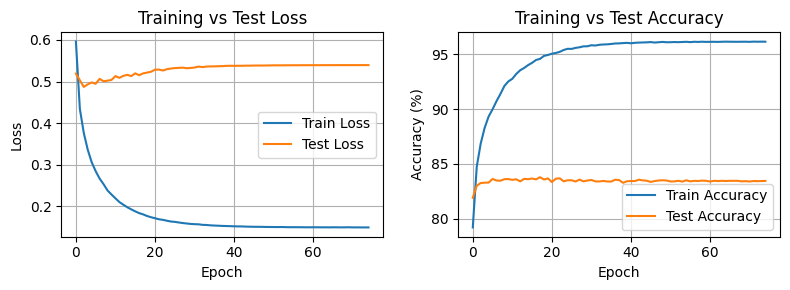

In [18]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Test Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
